In [1]:
import pandas as pd
df = pd.read_csv('data.csv')
print(df.shape)
print(df.info())
print(df.head())


(16857, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16857 entries, 0 to 16856
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   timestamp                     16857 non-null  object 
 1   equipment_energy_consumption  16013 non-null  object 
 2   lighting_energy               16048 non-null  object 
 3   zone1_temperature             15990 non-null  object 
 4   zone1_humidity                16056 non-null  object 
 5   zone2_temperature             16004 non-null  object 
 6   zone2_humidity                15990 non-null  float64
 7   zone3_temperature             16055 non-null  float64
 8   zone3_humidity                15979 non-null  float64
 9   zone4_temperature             16041 non-null  float64
 10  zone4_humidity                16076 non-null  float64
 11  zone5_temperature             16019 non-null  float64
 12  zone5_humidity                16056 non-null  fl

In [2]:
# Keep timestamp separate for now
timestamp_col = df['timestamp']

# Convert object columns (except 'timestamp') to numeric, coercing errors to NaN
for col in df.columns:
    if df[col].dtype == 'object' and col != 'timestamp':
        df[col] = pd.to_numeric(df[col], errors='coerce')


In [3]:
# Count missing values
missing_counts = df.isnull().sum()
print("Missing values per column:\n", missing_counts[missing_counts > 0])

# Optional: Percentage missing
missing_percent = (missing_counts / len(df)) * 100
print("Percentage missing:\n", missing_percent[missing_percent > 0])


Missing values per column:
 equipment_energy_consumption    912
lighting_energy                 864
zone1_temperature               949
zone1_humidity                  888
zone2_temperature               923
zone2_humidity                  867
zone3_temperature               802
zone3_humidity                  878
zone4_temperature               816
zone4_humidity                  781
zone5_temperature               838
zone5_humidity                  801
zone6_temperature               848
zone6_humidity                  847
zone7_temperature               794
zone7_humidity                  805
zone8_temperature               848
zone8_humidity                  777
zone9_temperature               773
zone9_humidity                  888
outdoor_temperature             806
atmospheric_pressure            842
outdoor_humidity                799
wind_speed                      828
visibility_index                815
dew_point                       826
random_variable1                826


In [4]:
# Convert to datetime
df['timestamp'] = pd.to_datetime(timestamp_col, errors='coerce')

# Extract time-based features
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek

# Drop original timestamp
df = df.drop(columns=['timestamp'])


In [5]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)


In [8]:
# Check for invalid values in the target
print(df_imputed['equipment_energy_consumption'].describe())
print("Min value:", df_imputed['equipment_energy_consumption'].min())

# Remove rows where target is missing or negative
df_imputed = df_imputed[df_imputed['equipment_energy_consumption'] > 0]


count    16543.000000
mean         4.349554
std          0.698052
min          2.397895
25%          3.931826
50%          4.110874
75%          4.615121
max          7.039648
Name: equipment_energy_consumption, dtype: float64
Min value: 2.3978952727983707


In [9]:
import numpy as np

df_imputed['equipment_energy_consumption'] = np.log1p(df_imputed['equipment_energy_consumption'])


In [10]:
# Check for remaining NaNs in features or target
print("Missing values after cleaning:", df_imputed.isnull().sum().sum())  # should be 0


Missing values after cleaning: 0


In [11]:
from sklearn.preprocessing import StandardScaler

# Split features and target
X = df_imputed.drop(columns=['equipment_energy_consumption'])
y = df_imputed['equipment_energy_consumption']

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Proceed with train/test split and model training as before


✅ Evaluation Results:
RMSE: 0.097
MAE: 0.067
R² Score: 0.358


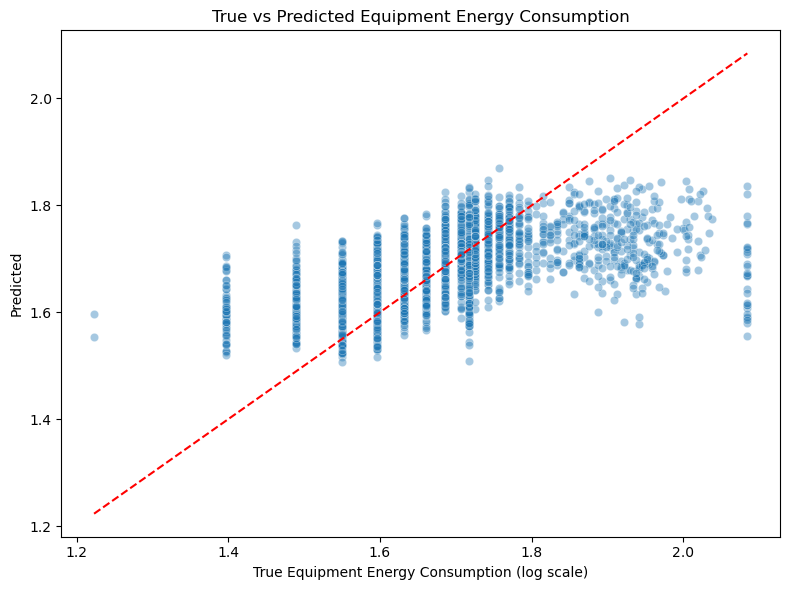

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Initialize and train model
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ Evaluation Results:")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R² Score: {r2:.3f}")

# Plot: True vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Equipment Energy Consumption (log scale)")
plt.ylabel("Predicted")
plt.title("True vs Predicted Equipment Energy Consumption")
plt.tight_layout()
plt.show()


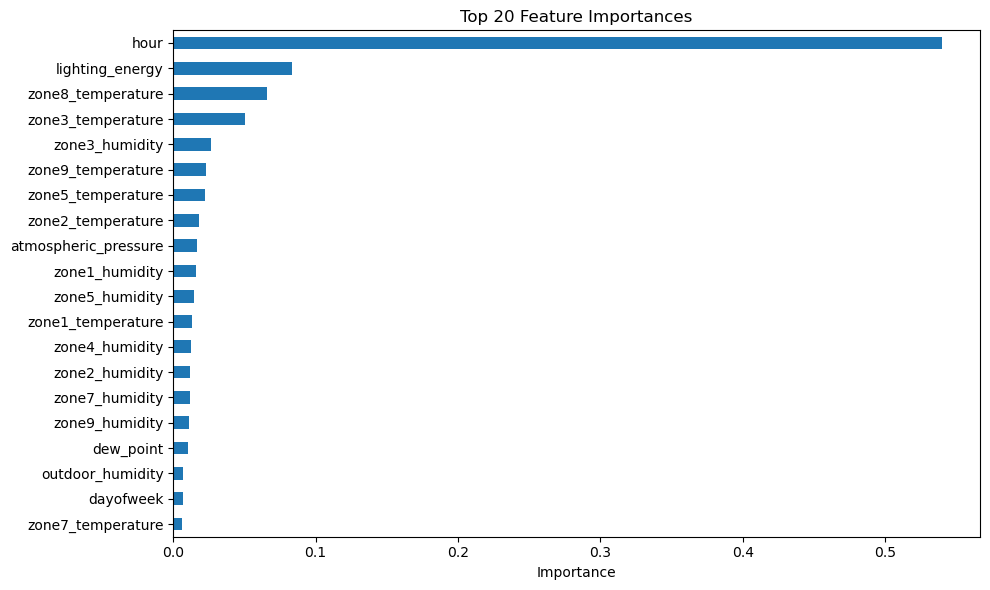

In [13]:
# Get feature importances from the trained model
importances = model.feature_importances_

# Create a Pandas Series with feature names
importances_series = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Plot top 20 most important features
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
importances_series[:20].plot(kind='barh')
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [14]:
# Check how important the random variables are
print("Importance of random_variable1:", importances_series.get('random_variable1', 'Not found'))
print("Importance of random_variable2:", importances_series.get('random_variable2', 'Not found'))


Importance of random_variable1: 0.0008538497107272269
Importance of random_variable2: 0.0009020160856161976


In [15]:
importances


array([0.08305581, 0.01336653, 0.01618251, 0.01802953, 0.011822  ,
       0.0507353 , 0.0268334 , 0.00590353, 0.01271385, 0.02212481,
       0.01455576, 0.00350638, 0.00563531, 0.00596678, 0.01154323,
       0.06594106, 0.00528514, 0.02297077, 0.01083556, 0.0046314 ,
       0.01655303, 0.00700897, 0.00313872, 0.00321438, 0.0105941 ,
       0.00085385, 0.00090202, 0.5395097 , 0.00658658])

In [16]:
importances_series

hour                    0.539510
lighting_energy         0.083056
zone8_temperature       0.065941
zone3_temperature       0.050735
zone3_humidity          0.026833
zone9_temperature       0.022971
zone5_temperature       0.022125
zone2_temperature       0.018030
atmospheric_pressure    0.016553
zone1_humidity          0.016183
zone5_humidity          0.014556
zone1_temperature       0.013367
zone4_humidity          0.012714
zone2_humidity          0.011822
zone7_humidity          0.011543
zone9_humidity          0.010836
dew_point               0.010594
outdoor_humidity        0.007009
dayofweek               0.006587
zone7_temperature       0.005967
zone4_temperature       0.005904
zone6_humidity          0.005635
zone8_humidity          0.005285
outdoor_temperature     0.004631
zone6_temperature       0.003506
visibility_index        0.003214
wind_speed              0.003139
random_variable2        0.000902
random_variable1        0.000854
dtype: float64